# Image Processing in FPGA

## Image Rotation
already done see: http://wpwiki/doku.php?id=internal:vhdl:components:imagerotation

## Linear Interpolation
See formula at:  https://en.wikipedia.org/wiki/Linear_interpolation
If the two known points are given by the coordinates $(x_0,y_0)$ and $(x_1,y_1)$, the '''linear interpolant''' is the straight line between these points. For a value $x$ in the interval $(x_0, x_1)$, the value $y$ along the straight line is given from the equation

$$ \frac{y - y_0}{x - x_0} = \frac{y_1 - y_0}{x_1 - x_0} $$

which can be derived geometrically from the figure on the right. It is a special case of polynomial interpolation with $n = 1$.

Solving this equation for $y$, which is the unknown value at $x$, gives

$$ y = y_0 + (y_1-y_0)\frac{x - x_0}{x_1-x_0} $$

![Linear-Interpolationn](Image_Processing/LinearInterpolation.svg)


Point(x,y) = (2.5, 3.5)


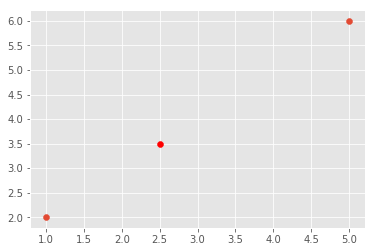

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def linear_interpolation(x, points):
  '''Interpolate (y) from x value associated with 2 points.

  The points are a list : (x, y).
  The two points can be in any order
      >>> bilinear_interpolation(2.5,
      ...                        [(1, 2),
      ...                         (5, 6)])    
  '''
  points = sorted(points)               # order points by x, then by y
  (x0, y0), (x1, y1) = points
  y =  y0 * (x - x1) / (x0 - x1) + y1 * (x - x0) / (x1 - x0);
  return (x, y)

n = [(5, 6),
     (1, 2),
    ]
(p_x, p_y) = linear_interpolation(2.5, n)
print("Point(x,y) = ({}, {})".format(p_x, p_y))

# Matplot
x, y = zip(*n)
plt.style.use('ggplot')
plt.scatter(x, y)

plt.scatter(p_x, p_y, c='r')


## Bilinear Interpolation
See formula at:  http://en.wikipedia.org/wiki/Bilinear_interpolation
We first do linear interpolation in the ''x''-direction. This yields
$$ f(x, y_1) \approx \frac{x_2-x}{x_2-x_1} f(Q_{11}) + \frac{x-x_1}{x_2-x_1} f(Q_{21}) $$
$$ f(x, y_2) \approx \frac{x_2-x}{x_2-x_1} f(Q_{12}) + \frac{x-x_1}{x_2-x_1} f(Q_{22}) $$
We proceed by interpolating in the ''y''-direction to obtain the desired estimate:
$$ f(x,y) \approx \frac{y_2-y}{y_2-y_1} f(x, y_1) + \frac{y-y_1}{y_2-y_1} f(x, y_2) $$

![Bilinear-Interpolationn](Image_Processing/BilinearInterpolation.svg)

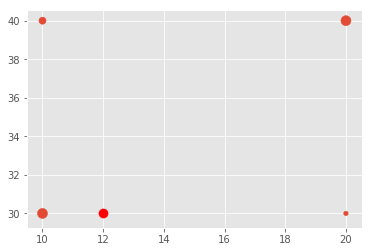

In [2]:
def bilinear_interpolation(x, y, points):
    '''Interpolate (x,y) from values associated with four points.

    The four points are a list of four triplets:  (x, y, value).
    The four points can be in any order.  They should form a rectangle.

        >>> bilinear_interpolation(12, 5.5,
        ...                        [(10, 4, 100),
        ...                         (20, 4, 200),
        ...                         (10, 6, 150),
        ...                         (20, 6, 300)])
        165.0
    '''
    points = sorted(points)               # order points by x, then by y
    (x1, y1, q11), (_x1, y2, q12), (x2, _y1, q21), (_x2, _y2, q22) = points

    if x1 != _x1 or x2 != _x2 or y1 != _y1 or y2 != _y2:
        raise ValueError('points do not form a rectangle')
    if not x1 <= x <= x2 or not y1 <= y <= y2:
        raise ValueError('(x, y) not within the rectangle')

    value = (q11 * (x2 - x) * (y2 - y) +
             q21 * (x - x1) * (y2 - y) +
             q12 * (x2 - x) * (y - y1) +
             q22 * (x - x1) * (y - y1)
            ) / ((x2 - x1) * (y2 - y1) + 0.0)
    return (x, y, value)

#n = [(54.5, 17.041667, 31.993),
#     (54.5, 17.083333, 31.911),
#     (54.458333, 17.041667, 31.945),
#     (54.458333, 17.083333, 31.866),
#    ]
n = [(10, 30, 100), # (x1, y1, q11)
     (10, 40, 50),  # (_x1, y2, q12)
     (20, 30, 20),  # (x2, _y1, q12)
     (20, 40, 100), # (_x2, _y2, q12)
    ]

(p_x, p_y, p_v) = bilinear_interpolation(12, 30, n)

# Matplot
x, y, v = zip(*n)
plt.style.use('ggplot')
plt.scatter(x, y, s=v)

plt.scatter(p_x, p_y, s=p_v, c='r')

## Image Mapping to Surface
There are multiple corrections which can be done:
* Density Correction - Conical Form - bigger diameter = lighter image
* Time of Flight (TOF) Correction - Distance PH <-> Substrate - Bigger distance = misplaced dot
* Nozzle Correction - Conical Form - smaller diameter = less focus on image
* Intelligent Quantizer - only logic for choosing the closest image

In [5]:
import math
import numpy as np
import numpy.matlib
import random
##
## Parameters
############################################################################################################################
## Image Parameters

class Quantizer():
  def __init__(self, enableIntelligentQuantize):
    
    self.enableIntelligentQuantize = enableIntelligentQuantize
    self.minimum = 0
    self.maximum = 255
    
    random.seed()
    
  def quantize(self, value):
    if self.enableIntelligentQuantize:
      # round down value
      quantizedValue = math.floor(value)
      # generate random number in the interval [0,1]
      r = random.random()
      # round up (i.e. add one) according to random number and distance of value to previous integer
      if ((value - quantizedValue) >= r):
        quantizedValue += 1
      # clip quantized value to allowd range
      return min(max(quantizedValue, self.minimum), self.maximum)
    else:
      return min(max(round(value), self.minimum), self.maximum);
    
class Points_2d:
  def __init__(self):
    x = []
    y = []
class Points_3d:
  def __init__(self):
    x = []
    y = []
    z = []

class ImageParameters:
  def __init__(self):
    self.offsetX    = 0
    self.flipX      = False
    self.flipY      = False
    self.grayLevels = [0.0/255, 63.0/255, 126.0/255, 189.0/255, 255.0/255] # (allowed graylevel in range [0,1])
    # uninitialized values
    self.height     = 0
    self.width      = 0
    self.nPixelsY   = 0
    self.nPixelsX   = 0
    self.offsetY    = 0
  
  def calcImageSize(nozzlePosY, realPixelSizeY_mm, cupCircumference):
    self.height = len(parameters.printHead.nozzlePosY)*realPixelSizeY_mm;
    self.width  = cupCircumference
    
  def printParams(self):
    print("Image Parameters are:")
    print("  * Offset X   : {0}mm".format(self.offsetX))
    print("  * Flip X     : {0}".format(self.flipX))
    print("  * Flip Y     : {0}".format(self.flipY))
    print("  * Gray Levels: {0}".format(self.grayLevels))
    
## Cup Parameters
class CupParameters:
  def __init__(self, radius_top, radius_bottom, height_parallel, distance_big, distance_small):
    self.r_top      = radius_top
    self.r_bot      = radius_bottom
    self.d_top      = 2 * self.r_top
    self.d_bot      = 2 * self.r_bot
    self.h_parallel = height_parallel
    self.h_vertical = math.sqrt( pow(self.h_parallel,2) - pow((self.r_top-self.r_bot),2) )
    self.dist_big   = distance_big
    self.dist_small = distance_small
    if self.dist_big == self.dist_small:
      self.isConstantDistance = True
    else:
      self.isConstantDistance = False
    (self.c_big, self.c_small) = self.calcCircumference()
    
  def calcCircumference(self):
    return( (2 * self.r_top * math.pi), (2 * self.r_bot * math.pi) )
    
  def printParams(self):
    print("Cup Parameters are:")
    print("  * Radius Top         : {0}mm".format(self.r_top))
    print("  * Radius Bottom      : {0}mm".format(self.r_bot))
    print("  * Diameter Top       : {0}mm".format(self.d_top))
    print("  * Diameter Bottom    : {0}mm".format(self.d_bot))
    print("  * Height Vertical    : {0}mm".format(self.h_vertical))
    print("  * Height Parallel    : {0}mm".format(self.h_parallel))
    print("  * Distance Big       : {0}mm".format(self.dist_big))
    print("  * Distance Small     : {0}mm".format(self.dist_small))
    print("  * Constant Distance  : {0}".format(self.isConstantDistance))
    print("  * Circumference Big  : {0}mm".format(self.c_big))
    print("  * Circumference Small: {0}mm".format(self.c_small))
    
## Printhead Parameters
class PrintheadParameters:
  def __init__(self, ph_type):
    if ph_type == "KM1024iMHE":
      self.ph_type = ph_type
      self.vDrop = 6000 # velocity of drops in [mm/s]
      self.nozzlePosX = np.matlib.repmat([+20, -8, 8, -20], 256, 1) # repmat([+20;-8;+8;-20],[256 1])
      self.nozzlePosY = np.linspace(0, -2043, num=2044) #(0:-1:-2043)
      self.nominalResolutionX_dpi = 360
      self.nominalResolutionY_dpi = 25.4/0.0705
    elif type == "KM1024MH":
      self.ph_type = ph_type
      self.vDrop = 6000 # velocity of drops in [mm/s]
      self.nozzlePosX = np.matlib.repmat([-10, 10], 512, 1) # repmat([-10;+10],[512 1]) # simplified
      self.nozzlePosY = np.linspace(0, -1023, num=1024) #(0:-1:-1023)
      self.nominalResolutionX_dpi = 360
      self.nominalResolutionY_dpi = 25.4/0.0705
    (self.nominalPixelSizeX_mm, self.nominalPixelSizeY_mm) = self.calc_nominalPixelSize()

  def calc_nominalPixelSize(self):
    nominalPixelSizeX_mm = 25.4/self.nominalResolutionX_dpi
    nominalPixelSizeY_mm = 25.4/self.nominalResolutionY_dpi
    return (nominalPixelSizeX_mm, nominalPixelSizeY_mm)
  
  def printParams(self):
    print("Printhead Parameters are:")
    print("  * PH Type          : {0}".format(self.ph_type))
    print("  * Drop velocity    : {0}mm/s".format(self.vDrop))
    print("  * Nozzle Position X: {0}".format(self.nozzlePosX))
    print("  * Nozzle Position Y: {0}".format(self.nozzlePosY))
    print("  * Resolution X     : {0}dpi".format(self.nominalResolutionX_dpi))
    print("  * Resolution Y     : {0}dpi".format(self.nominalResolutionY_dpi))
    print("  * PixelSize X      : {0}mm".format(self.nominalPixelSizeX_mm))
    print("  * PixelSize Y      : {0}mm".format(self.nominalPixelSizeY_mm))
    
## Iamge Processing
class ImageProcessing:
  def __init__():
    pass
  def nominal2realPixelSize(self, phParameters, cupParameters):
    dt = cupParameters.r_top - cupParameters.r_bot

    d  = cupParameters.dist_big - cupParameters.dist_small
    Ht = cupParameters.h_vertical
    h  = phParameters.nominalPixelSizeY_mm
    
    H = math.sqrt(pow(Ht,2) + pow(dt,2) - pow(d,2))
    ht = h*Ht/H;
    
    realPixelSizeX = phParameters.nominalPixelSizeX
    realPixelSizeY = ht
    
    return (realPixelSizeX, realPixelSizeY)
  
  def generateIntensityImage(self, outpath, cupParameters, phParameters, imParameters):
    numberOfNozzles = len(phParameters.nozzlePosY)
    cupCircumference = cupParameters.self.c_big
    # determine Image dimensions
    imParameters.nPixelsY = numberOfNozzles
    imParameters.nPixelsX = math.ceil(cupCircumference*phParameters.nominalResolutionX_dpi/25.4)
    
    # generate Intensity map
    (intensityMap, maxValue) = self.generateIntensityMap()
    
    
    
  def generateIntensityMap(self, cupParameters, phParameters, imParameters):
    # compute cupCircumference
    cupCircumference = cupParameters.self.c_big
    
    # get nozzle layout
    (realPixelSizeX, realPixelSizeY) = nominal2realPixelSize(phParameters, cupParameters)
    
    # Complete domain and image parameters width and heigth
    imParameters.calcImageSize(phParameters.nozzlePosY, realPixelSizeY, cupCircumference)
    
    imagePoints = Points_2d()
    (imagePoints.x, imagePoints.y) = np.meshgrid(imParameters.nPixelsX, imParameters.nPixelsY)
    
    (domainPoints, jacobian) = self.transform_image2domain(imagePoints, imParameters);

    #[cupPoints, intensityMap] = getCupPoints(domainPoints, parameters.cup);

    # evaluate maximum value within active area (i.e. area within cup)
    #activeNozzles = 0<=domainPoints.y(:,1) &  domainPoints.y(:,1)<parameters.cup.H;
    #activeNozzleIndices = find(activeNozzles);
    #maxValue = max(intensityMap(activeNozzleIndices,:))

  def getCupPoints(self, s, h, cupParameters):
    cupPoints = Points_3d()
    intensity = 0
    return (cupPoints, intensity)
  
  
  def transform_image2domain(self, imagePoints, imParameters):
    domainPoints = Points_2d()
    if imParameters.flipX:
      domainPoints.x =  imParameters.offsetX + imParameters.width - imParameters.width*(imagePoints.x-1/2)/imagePoints.nPixelsX
      grad1 = [-imParameters.width/imParameters.nPixelsX, 0]
    else:
      domainPoints.x =  imParameters.offsetX + imParameters.width*(imagePoints.x-1/2)/imParameters.nPixelsX
      grad1 = [imParameters.width/imParameters.nPixelsX, 0]

    if imParameters.flipY:
      domainPoints.y =  imParameters.offsetY - imParameters.height*(1-(imagePoints.y-1/2)/imParameters.nPixelsY);
      grad2 = [0, imParameters.height/imParameters.nPixelsY]
    else:
      domainPoints.y =  imParameters.offsetY - imParameters.height + imParameters.height*(1-(imagePoints.y-1/2)/imParameters.nPixelsY);
      grad2 = [0, -imParameters.height/imParameters.nPixelsY]

    jabocian = (grad1, grad2)
    return (domainPoints, jacobian)
    
##
## Cup Wizard
############################################################################################################################
class CupWizard:
  def __init__(self, enableDensityCorrection, enableTOFCorrection, enableNozzleCorrection, enableIntelligentQuantizer):
    self.enableDensityCorrection    = enableDensityCorrection
    self.enableTOFCorrection        = enableTOFCorrection
    self.enableNozzleCorrection     = enableNozzleCorrection
    self.enableIntelligentQuantizer = enableIntelligentQuantizer
    
    # Create parameter instances
    cupParameters = CupParameters(radius_top=44.577, radius_bottom=33.4165, height_parallel=142.128, distance_big=3, distance_small=3)
    phParameters = PrintheadParameters(ph_type="KM1024iMHE")
    imParameters = ImageParameters()
    imParameters.offsetY = cupParameters.h_parallel
    quantizer = Quantizer(self.enableIntelligentQuantizer)
    
    # Print all Parameters
    cupParameters.printParams()
    phParameters.printParams()
    imParameters.printParams()
    
    # Density Correction (not implemented)
    if self.enableDensityCorrection:
      # generate intensity image
      pass
    
    # TOF Correction (not implemented)
    if self.enableTOFCorrection:
      pass
    # Nozzle Correction
    if self.enableNozzleCorrection:
      pass

In [6]:
cupImageProcessing = CupWizard(enableDensityCorrection=False, enableTOFCorrection=False, enableNozzleCorrection=True, enableIntelligentQuantizer=True)

Cup Parameters are:
  * Radius Top         : 44.577mm
  * Radius Bottom      : 33.4165mm
  * Diameter Top       : 89.154mm
  * Diameter Bottom    : 66.833mm
  * Height Vertical    : 141.68913728211487mm
  * Height Parallel    : 142.128mm
  * Distance Big       : 3mm
  * Distance Small     : 3mm
  * Constant Distance  : True
  * Circumference Big  : 280.0855514381444mm
  * Circumference Small: 209.96206181736665mm
Printhead Parameters are:
  * PH Type          : KM1024iMHE
  * Drop velocity    : 6000mm/s
  * Nozzle Position X: [[ 20  -8   8 -20]
 [ 20  -8   8 -20]
 [ 20  -8   8 -20]
 ..., 
 [ 20  -8   8 -20]
 [ 20  -8   8 -20]
 [ 20  -8   8 -20]]
  * Nozzle Position Y: [  0.00000000e+00  -1.00000000e+00  -2.00000000e+00 ...,  -2.04100000e+03
  -2.04200000e+03  -2.04300000e+03]
  * Resolution X     : 360dpi
  * Resolution Y     : 360.2836879432624dpi
  * PixelSize X      : 0.07055555555555555mm
  * PixelSize Y      : 0.0705mm
Image Parameters are:
  * Offset X   : 0mm
  * Flip X     : Fa